In [17]:
# Importing the needed libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from prettytable import PrettyTable
import matplotlib.patches as Patches

In [18]:
#Load the regional and national data into Pandas DataFrame

url = 'https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-regioni/dpc-covid19-ita-regioni.csv'
covid19_ita_full = pd.read_csv(url)

#Load the National data into another Pandas DataFrame
url_national = 'https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-andamento-nazionale/dpc-covid19-ita-andamento-nazionale.csv'
covid19_ita_nazionale = pd.read_csv(url_national)

# Filter and adjust the pandas dataframe so that the national data conform with the regional database

#New columns 
covid19_ita_nazionale['codice_regione'] = [0]*covid19_ita_nazionale.shape[0]
covid19_ita_nazionale['denominazione_regione'] = ['Italia']*covid19_ita_nazionale.shape[0]
covid19_ita_nazionale['lat'] = [0]*covid19_ita_nazionale.shape[0]
covid19_ita_nazionale['long'] = [0]*covid19_ita_nazionale.shape[0]

# Reorder the columns
covid19_ita_nazionale = covid19_ita_nazionale[list(covid19_ita_full.columns)]

#Append the national data to the regional database
covid19_ita = covid19_ita_full.append(covid19_ita_nazionale, ignore_index=True)

#Convert the string into a datetime object to keep track of time
covid19_ita['data']=pd.to_datetime(covid19_ita['data'],format="%Y-%m-%d %H:%M:%S") 
#covid19_ita.dtypes

#Retain only interesting data and rename columns
covid19_ita=covid19_ita.drop(columns=['stato', 'lat','long'])

#Translate header in English
covid19_ita.columns = ['date', 'code_region', 'region', 'checked_in','intensive_care','total_admitted','home_isolation','currently_positive','new_positives','recovered','deceased','total_cases','swabs']

#Seaborn setup for plots
sns.set(rc={'figure.figsize':(11, 7)})

### Here we load the previously fitted data and plot both data and fit

Available indicator are:
- region = Name of the italia region of interest
- total_admitted = Total number of people checked in at the Hospital due to COVID19
- intensive_care = Number of patients in intensive care
- checked_in = Number of patients at the Hospital, but not in intensive care
- home_isolation = Number of positive cases in isolation at home
- currently_positive = Daily count of confirmed cases of COVID19 
- new_positives = Number of daily new positive cases
- recovered = Daily number of people who left the hospital because of healing
- deceased = Total count of people who died due to COVID19
- total_cases = Total number of records of people with COVID19
- swabs = Number of COVID19 tests that have been done

Names of the regions:
- 'Abruzzo', 'Basilicata', 'P.A. Bolzano', 'Calabria', 'Campania','Emilia Romagna', 'Friuli Venezia Giulia', 'Lazio', 'Liguria','Lombardia', 'Marche', 'Molise', 'Piemonte', 'Puglia', 'Sardegna','Sicilia', 'Toscana', 'P.A. Trento', 'Umbria', 'Valle d'Aosta','Veneto', 'Italia'

In [19]:
#Function to plot the indicators in "indicator_to_plot" for a list of regions specificed in "region_list"
def plot_data(region_list,indicator_to_plot,x_lim=None,y_lim=None,y_scale='linear'):
    for n in indicator_to_plot:
        plt.figure(figsize=(14,8))
        ax = plt.gca()
        for k in region_list:
            df = covid19_ita[covid19_ita.region==k]
            df.plot(x='date',y=n,ax=ax,label=k)
            plt.yscale(y_scale)
            plt.legend()
        plt.xlim(x_lim)
        plt.ylim(y_lim)
        plt.ylabel(n)
    plt.show()

### Functions to plot both Data and Fit

In [20]:
#Growth used: Verhulst model. Explanation in COVID19_CompartmentalModels
def Verhulst(t, K, I0, r):
    return (K*I0*np.exp(r*t))/(K+I0*(np.exp(r*t)-1))

In [21]:
#Create the numpy arra for the time. Needed for curve_fit. The time-scale is in days
def time_vector(data_frame):
    time_frame = data_frame[data_frame.region=='Italia']['date'].to_numpy()
    t_vec = np.zeros(len(time_frame))
    for k in range(len(time_frame)):
        t_vec[k] = ((time_frame[k]-time_frame[0]).item())/(np.power(10,9)*60*60*24)
    return t_vec

In [85]:
#Plots by indicator, for a list of regions specificed in region_list
def plot_fit_by_indicator(region_list,indicator_to_plot,future_days=0,x_lim=None,y_lim=None,y_scale='linear',save_fig='No'):
    #Define an array of "Future data" to continue the plot and extract a prediction
    future_tdata = np.linspace(time_vector(covid19_ita)[-1],time_vector(covid19_ita)[-1]+future_days,num=10*future_days)
    new_tdata = np.append(time_vector(covid19_ita),future_tdata)
    for n in indicator_to_plot:
        plt.figure(figsize=(14,10))
        ax = plt.gca()
        t_indicator = PrettyTable(['Indicator = {}'.format(n), 'Value','Error'])
        dely_textbox = 0
        for k in region_list:
            url_paras = './Fit_Data/Regions/Verhulst_Parameters_{}.csv'.format(k)
            aux = pd.read_csv(url_paras)
            verhulst_paras = aux.set_index('indicator')
            ax.plot(new_tdata, Verhulst(new_tdata, verhulst_paras['K'][n],verhulst_paras['I0'][n],verhulst_paras['r'][n]),label='{}'.format(k),linewidth=3)
            ax.plot(time_vector(covid19_ita), covid19_ita[covid19_ita.region==k][n],'o',markersize=12)
            ax.tick_params(labelsize=23)
            t_indicator.add_row(['Carrying Capacity {}'.format(k),verhulst_paras['K'][n],verhulst_paras['delta_K'][n]])
            t_indicator.add_row(['Growth rate {}'.format(k),verhulst_paras['r'][n],verhulst_paras['delta_r'][n]])
            plt.yscale(y_scale)
            ax.legend(ncol=min(len(region_list),4), bbox_to_anchor=(0, 1),loc='lower left', fontsize=23)
            
            #Code to insert text with optimal value of the parameters
            textstr = '\n'.join((
                r'$K_\mathrm{{{}}}={{{:.0f}}} \pm {{{:.0f}}}$'.format(k,verhulst_paras['K'][n],verhulst_paras['delta_K'][n]),
                r'$r_\mathrm{{{}}}={{{:.3f}}} \pm {{{:.3f}}}$'.format(k,verhulst_paras['r'][n],verhulst_paras['delta_r'][n]) ))

            # these are matplotlib.patch.Patch properties
            props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

            # place a text box in upper left in axes coords
            ax.text(0.05, 0.20+dely_textbox, textstr, transform=ax.transAxes, fontsize=20,verticalalignment='top', bbox=props)
            dely_textbox = dely_textbox + 0.15
            
            
        print(t_indicator)
        plt.xlim(x_lim)
        plt.ylim(y_lim)
        plt.ylabel(n,fontsize=23)
        plt.xlabel('Days from 24th of February',fontsize=23)
        if save_fig=='Yes':
            plt.savefig('./Plots/ByIndicator/{}_{}'.format(n,'_'.join(region_list)))
    plt.show()

In [86]:
#Plot by region, for a list of indicators specified in indicator_to_plot
def plot_fit_by_region(region_list,indicator_to_plot,future_days=0,x_lim=None,y_lim=None,y_scale='linear',save_fig='No'):
    #Define an array of "Future data" to continue the plot and extract a prediction
    future_tdata = np.linspace(time_vector(covid19_ita)[-1],time_vector(covid19_ita)[-1]+future_days,num=10*future_days)
    new_tdata = np.append(time_vector(covid19_ita),future_tdata)
    
    for k in region_list:
        plt.figure(figsize=(14,8))
        ax = plt.gca()
        t_indicator = PrettyTable(['Region = {}'.format(k), 'Value','Error'])
        dely_textbox = 0
        for n in indicator_to_plot:
            url_paras = './Fit_Data/Indicators/Verhulst_Parameters_{}.csv'.format(n)
            aux = pd.read_csv(url_paras)
            verhulst_paras = aux.set_index('region')
            ax.plot(new_tdata, Verhulst(new_tdata, verhulst_paras['K'][k],verhulst_paras['I0'][k],verhulst_paras['r'][k]),label='{}'.format(n),linewidth=3)
            ax.plot(time_vector(covid19_ita), covid19_ita[covid19_ita.region==k][n],'o',markersize=12)
            ax.tick_params(labelsize=23)
            t_indicator.add_row(['Carrying Capacity {}'.format(n),verhulst_paras['K'][k],verhulst_paras['delta_K'][k]])
            t_indicator.add_row(['Growth rate {}'.format(n),verhulst_paras['r'][k],verhulst_paras['delta_r'][k]])
            plt.yscale(y_scale)
            ax.legend(ncol=min(len(region_list),4), bbox_to_anchor=(0, 1),loc='lower left', fontsize=23)
            
            
            #Code to insert text with optimal value of the parameters
            textstr = '\n'.join((
                r'$K_\mathrm{{{}}}={{{:.0f}}} \pm {{{:.0f}}}$'.format(n,verhulst_paras['K'][k],verhulst_paras['delta_K'][k]),
                r'$r_\mathrm{{{}}}={{{:.3f}}} \pm {{{:.3f}}}$'.format(n,verhulst_paras['r'][k],verhulst_paras['delta_r'][k]) ))

            # these are matplotlib.patch.Patch properties
            props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

            # place a text box in upper left in axes coords
            ax.text(0.05, 0.20+dely_textbox, textstr, transform=ax.transAxes, fontsize=20,verticalalignment='top', bbox=props)
            dely_textbox = dely_textbox + 0.15
            
        print(t_indicator)
        plt.xlim(x_lim)
        plt.ylim(y_lim)
        plt.ylabel(k,fontsize=23)
        plt.xlabel('Days from 24th of February',fontsize=23)
        if save_fig=='Yes':
            plt.savefig('./Plots/ByRegion/{}_{}'.format(k,'_'.join(indicator_to_plot)))
    plt.show()

## Usage of plot functions and arguments that can be used

- To plot national data use 'Italia' as name of the region
- plot_fit_by_region(region_list,indicator_to_plot,future_days=0,x_lim=None,y_lim=None,y_scale='linear')
- plot_fit_by_indicator(region_list,indicator_to_plot,future_days=0,x_lim=None,y_lim=None,y_scale='linear')

### Allowed arguments
- **region_list**: *list* - regions we are interested in - e.g. ['Piemonte','Lombardia']
- **indicator_list**: *list* - indicators we would like to look at - e.g. ['deceased','currently_positive']
- **future_days**: *integer* - number of days you want to continue the fit to extract a future prediction
- **x_lim**: *list* of two non-negative *integers* - set the time-window of interest. The zero is the 24th of February - e.g. x_lim=[0,20]
- **y_lim**: *list* of two non-negative  *integers* - set the vertical window of interest. e.g. y_lim=[0,200]
- **y_scale**: choose the y-scale of the plot. Default is linear. e.g. y_scale='log'
- **save_fig** *string* can be either 'Yes', or 'No'. Default is no. Saves the plot in one of the two dedicated folders: Plots/ByRegion or Plots/ByIndicator

### Example 1: National data and fit on the number of people currently positive

+--------------------------------+--------------------+-----------------------+
| Indicator = currently_positive |       Value        |         Error         |
+--------------------------------+--------------------+-----------------------+
|    Carrying Capacity Italia    | 51571.536412508496 |   2995.6781542300537  |
|       Growth rate Italia       | 0.2259954695707226 | 0.0053422316173420345 |
+--------------------------------+--------------------+-----------------------+


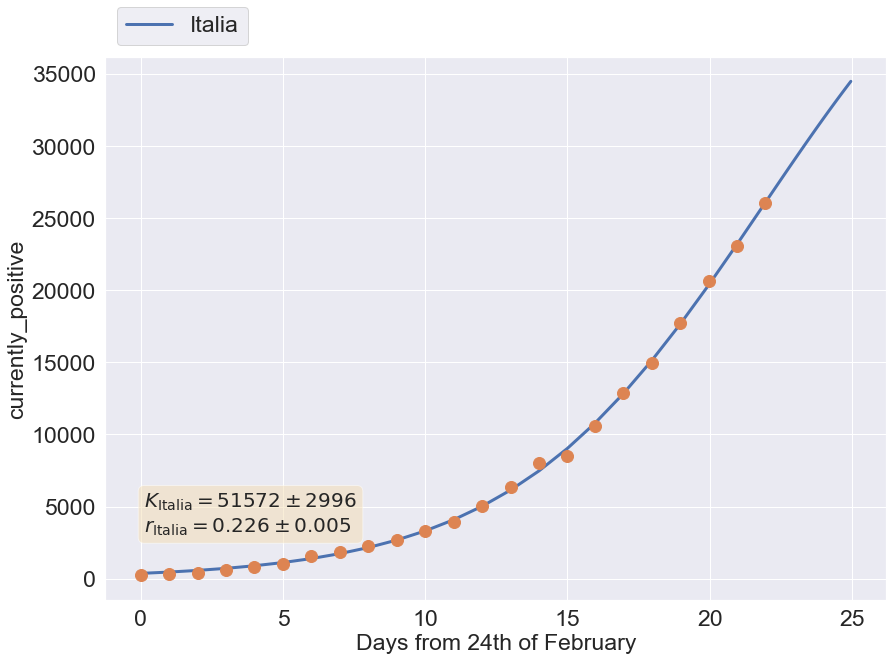

In [95]:
region_list=['Italia']
indicator_list=['currently_positive']
plot_fit_by_indicator(region_list,indicator_list,future_days=3,save_fig='Yes')

### Example 2: number of people in intensive care and deceased for two regions: Veneto and Piemonte

+----------------------------------+---------------------+----------------------+
|        Region = Piemonte         |        Value        |        Error         |
+----------------------------------+---------------------+----------------------+
| Carrying Capacity intensive_care |  272.35598263910083 |  18.70795092776078   |
|    Growth rate intensive_care    | 0.32376950697061524 | 0.020310675805937477 |
|    Carrying Capacity deceased    |  266.58417834334574 |  31.770816283948164  |
|       Growth rate deceased       |  0.4129801023442394 | 0.020940094166996357 |
+----------------------------------+---------------------+----------------------+
+----------------------------------+---------------------+---------------------+
|         Region = Veneto          |        Value        |        Error        |
+----------------------------------+---------------------+---------------------+
| Carrying Capacity intensive_care |   431.18231529411   |  80.00802354514902  |
|    Growth rate int

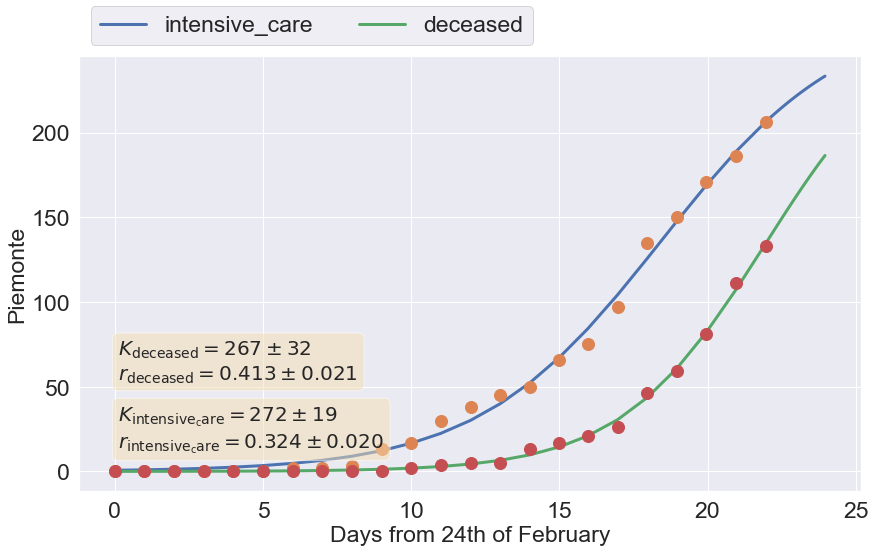

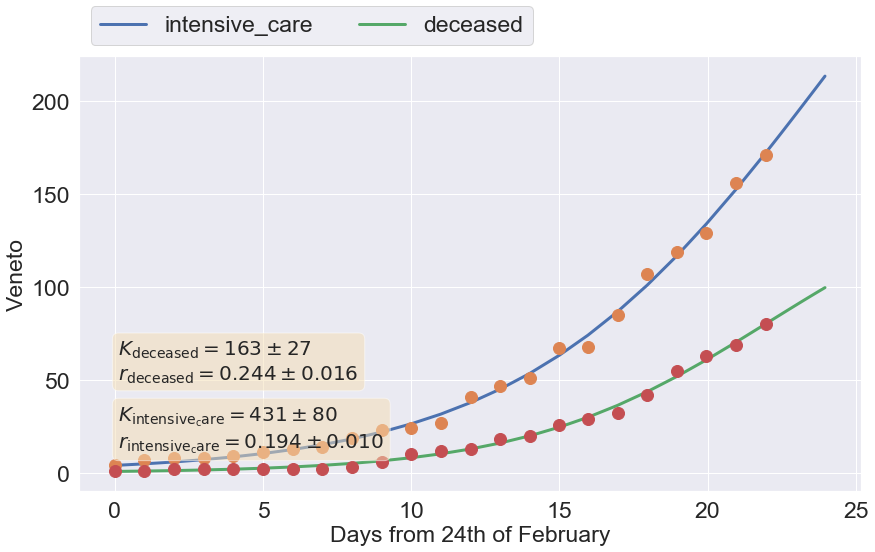

In [94]:
region_list=['Piemonte','Veneto']
indicator_list=['intensive_care','deceased']
plot_fit_by_region(region_list,indicator_list,future_days=2,save_fig='Yes')

### Example 3: number of people in intensive care and deceased for two regions: Lombardia and Piemonte

+-----------------------------+---------------------+----------------------+
|  Indicator = intensive_care |        Value        |        Error         |
+-----------------------------+---------------------+----------------------+
| Carrying Capacity Lombardia |  1055.7197274065413 |  43.384118596124424  |
|    Growth rate Lombardia    |  0.2272860097828469 | 0.010283982814652131 |
|  Carrying Capacity Piemonte |  272.35598263910083 |  18.70795092776078   |
|     Growth rate Piemonte    | 0.32376950697061524 | 0.020310675805937477 |
+-----------------------------+---------------------+----------------------+
+-----------------------------+--------------------+----------------------+
|     Indicator = deceased    |       Value        |        Error         |
+-----------------------------+--------------------+----------------------+
| Carrying Capacity Lombardia | 2523.804654499977  |  210.7034323707459   |
|    Growth rate Lombardia    | 0.3031659814973033 | 0.015747071888111332 |
|  C

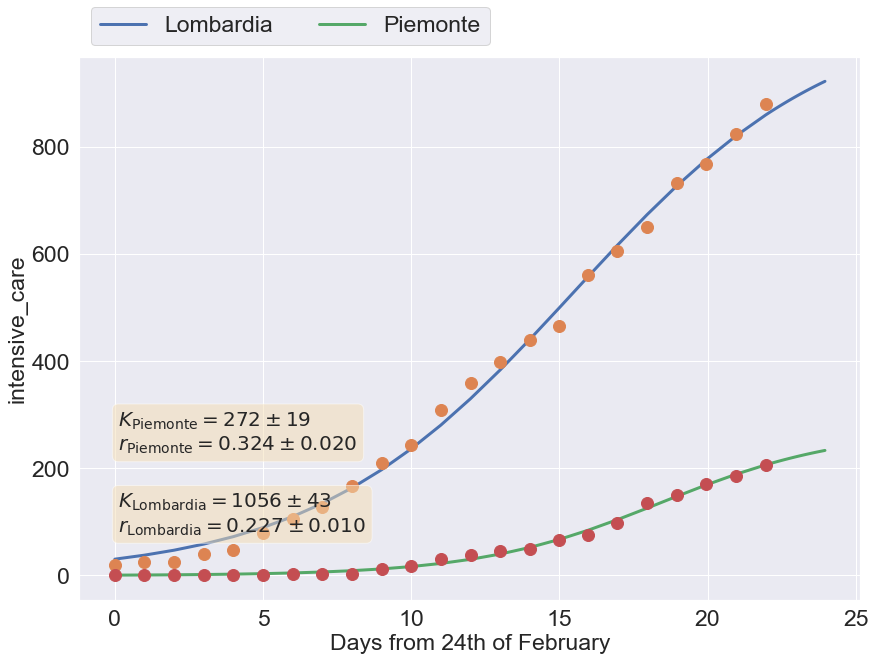

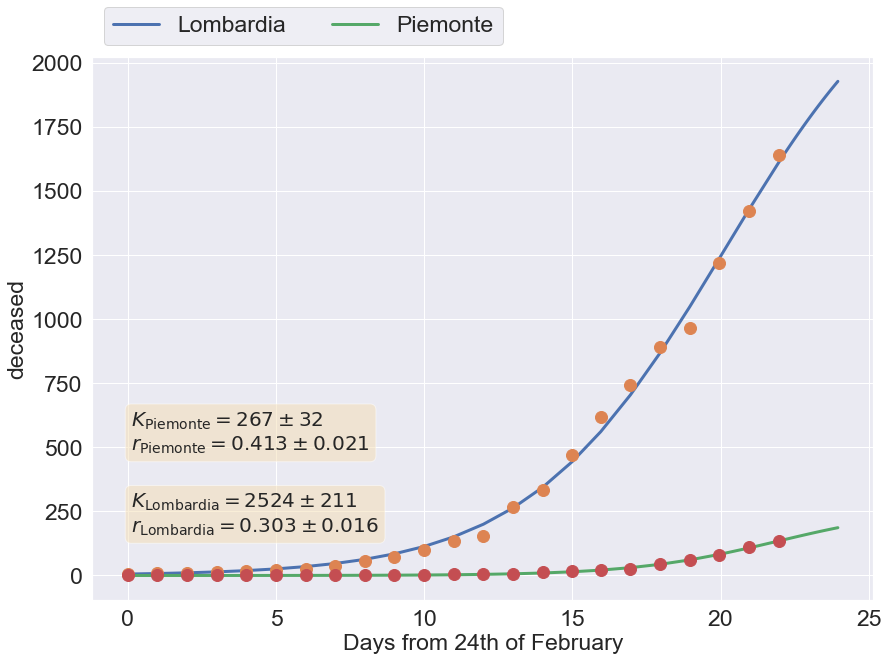

In [93]:
region_list=['Lombardia','Piemonte']
indicator_list=['intensive_care','deceased']
plot_fit_by_indicator(region_list,indicator_list,future_days=2,save_fig='Yes')